# Some NLP: Spelling Correction with Noisy Channel Model

The following problem appeared as an assignment in the *coursera course Natural Languange Processing (by Stanford university)*. The following description of the problem is taken from the assignment description and the course slides.

In [5]:
#ipython nbconvert pcaiso.ipynb
%matplotlib inline

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

The following figure shows the basic concepts of spelling correction using the **noisy channel model**. Given the **misspelt word**, the **most probable correct word** can be computed by 
1. **generating** the possible correct words (from the *vocabulary*) with some **edit-distance model**.
2. **estimating** the **prior** and the **likelihood** probabilities using some **language model**.
3. **computing** the **posterior** probabilities and the **MAP estimate** using the **Bayes Theorem**.

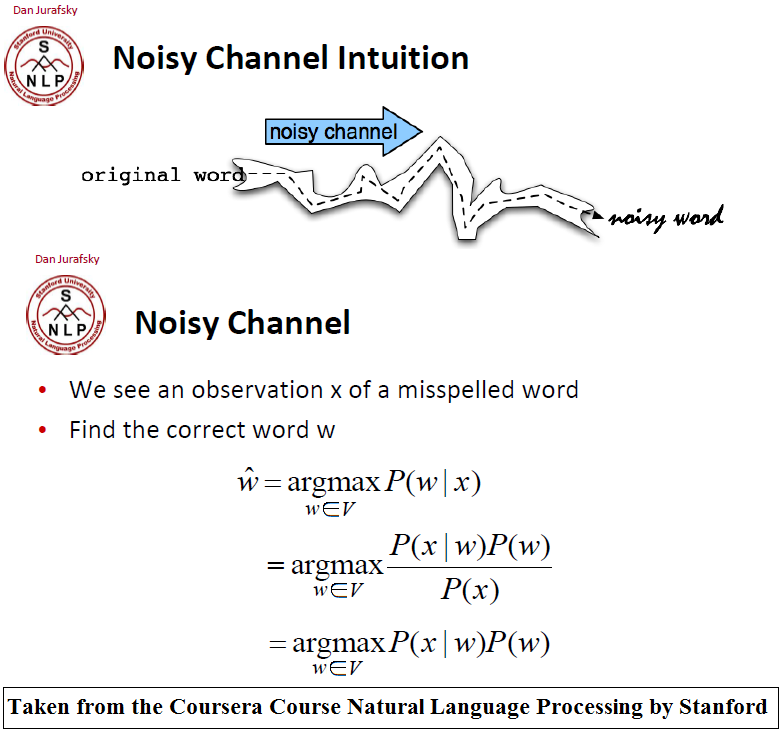

In [1]:
from IPython.display import Image
Image(filename='C:/courses/Coursera/Past/NLP/Stanford - NLP/Assignment/pa2-autocorrect-v1/im0.png')

The following figure shows how the candidate words (possible correct words) can be generated (mostly the words within *edit distance 1*) and then a suitable language model can be used to estimate (with *MLE*) the *prior* and the *likelihood* (insertion / deletion etc.) proabilities from the training corpus.

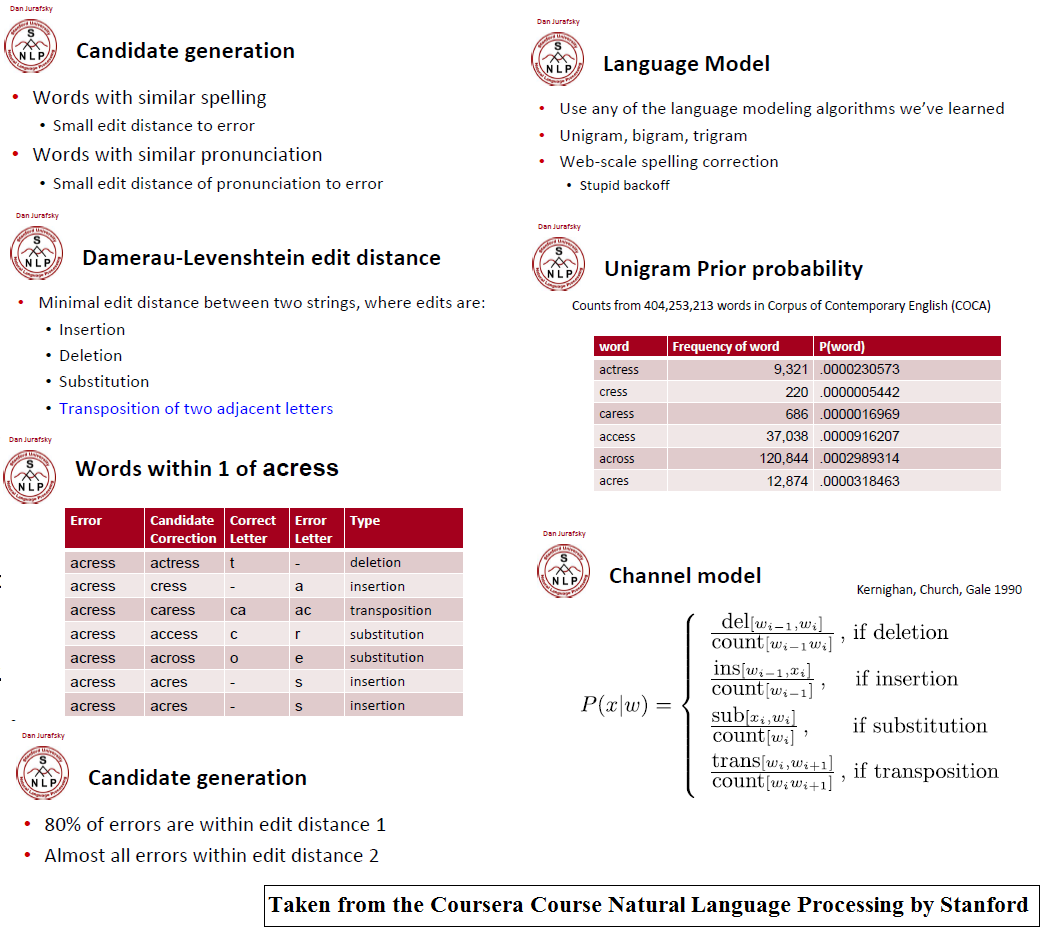

In [2]:
Image(filename='C:/courses/Coursera/Past/NLP/Stanford - NLP/Assignment/pa2-autocorrect-v1/im0_1.png')

The following figure shows the **real world spelling correction** methods using the **noisy channel model**, we are going to use these techniques to solve the spelling-correction problem. Given a *k-word* sentence $W=w_1,w_2,\ldots, w_k$, we are going to apply the following steps to compute the most probable sentence with the possibly-corrected misspelt-words:
1. For each word *w_i* generate the candidate set (e.g., the words that are withing *1-edit distance*).
2. Use a *langauge model* to compute the probability of a sequence *P(W)* and then find the *most probable sequence W*.

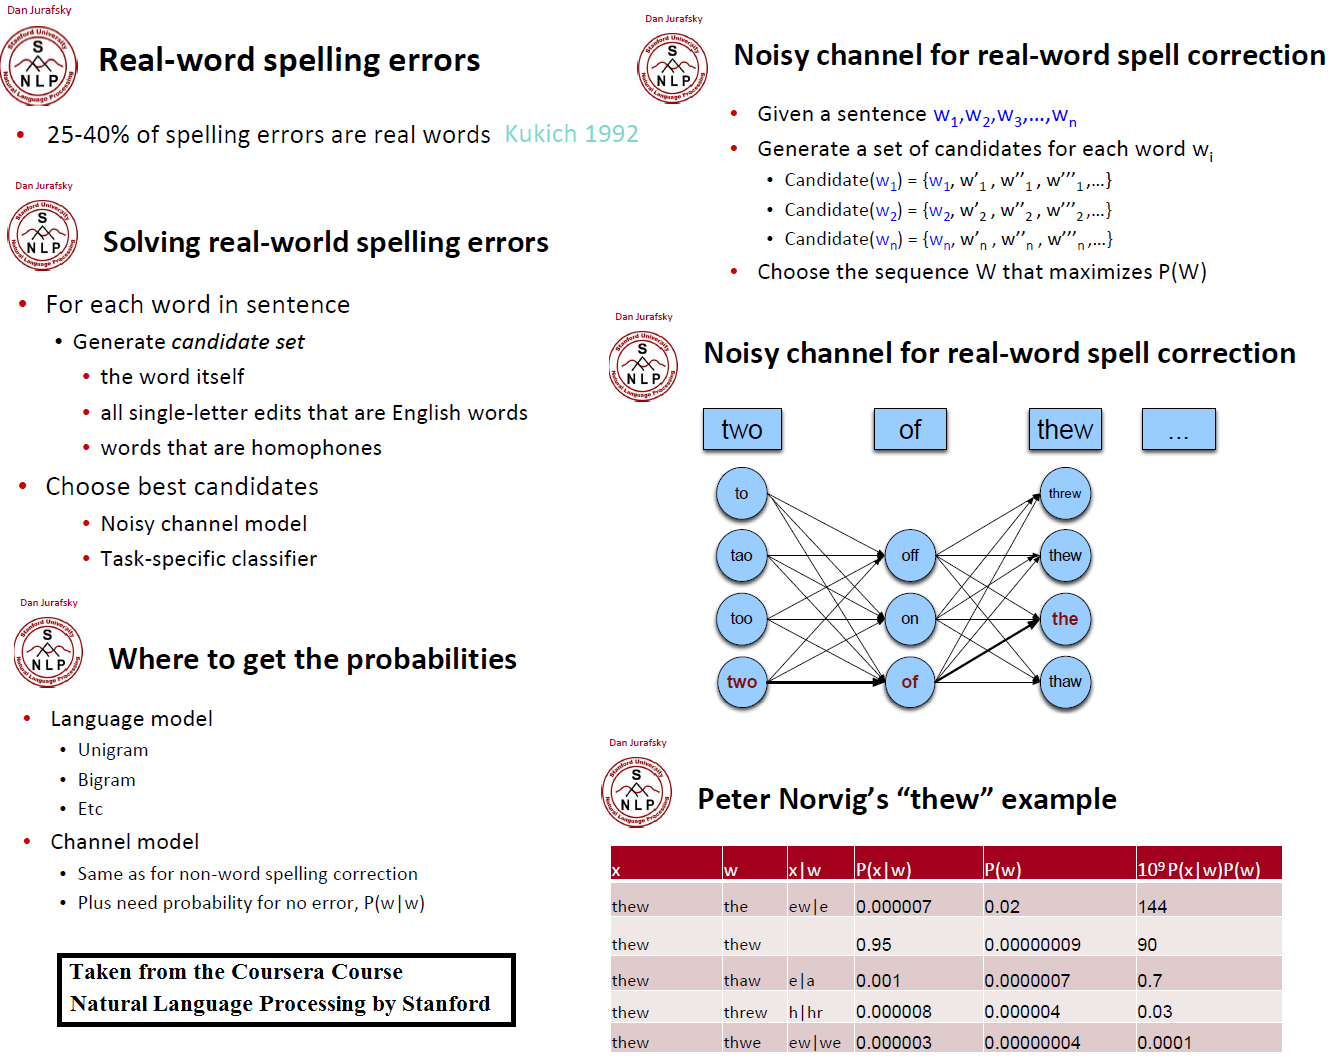

In [3]:
Image(filename='C:/courses/Coursera/Past/NLP/Stanford - NLP/Assignment/pa2-autocorrect-v1/im0_2.png')

The following figure shows the different **language models** that are going to be used to compute the **MLE** (without / with **smoothing**) probabilities and also how they can be used to compute the probability of a sentence (i.e. a sequence of words). 

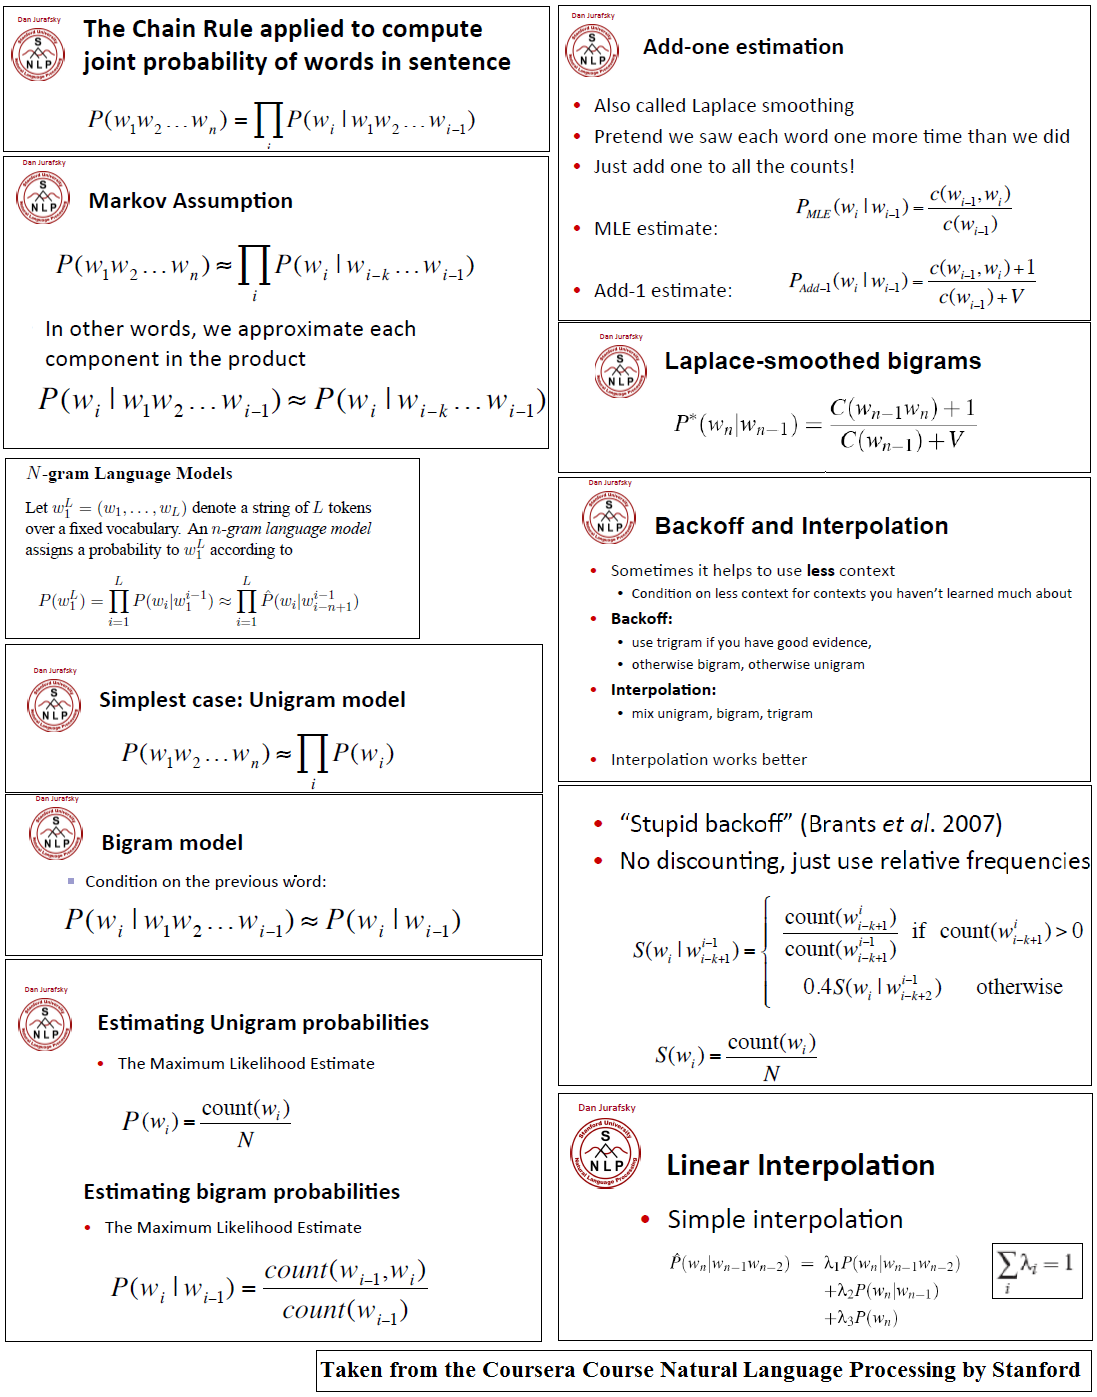

In [4]:
Image(filename='C:/courses/Coursera/Past/NLP/Stanford - NLP/Assignment/pa2-autocorrect-v1/im1.png')

1. Given a **training corpus**, the **parameters** for the **language models** are first estimated from the corpus.
2. Then these probabilities are used to compute the most probable (possibly spell-corrected) sequence of candidate words for each sentence in the **dev corpus**.
3. The **accuracy** of **spell-correction** on the **dev corpus** is computed using the ground truth for each **language model** and reported.

## Results

The following results show the **accuracy** of **spell-correction** using the different **language models** on the **dev corpus**:

1. **Uniform Language Model**: correct: 31 total: 471 accuracy: **0.065817**

2. **Unigram Language Model**: correct: 29 total: 471 accuracy: **0.061571**

3. **Laplace Unigram Language Model**: correct: 52 total: 471 accuracy: **0.110403**

4. **Laplace Bigram Language Model**: correct: 64 total: 471 accuracy: **0.135881**

5. **Stupid Backoff Language Model**: correct: 85 total: 471 accuracy: **0.180467**

6. **Custom Language Model (Simple Linear Interpolation $\lambda_1=0.17, \lambda_2=0.39, \lambda_3=0.44$)**: correct: 91 total: 471 accuracy: **0.193206**

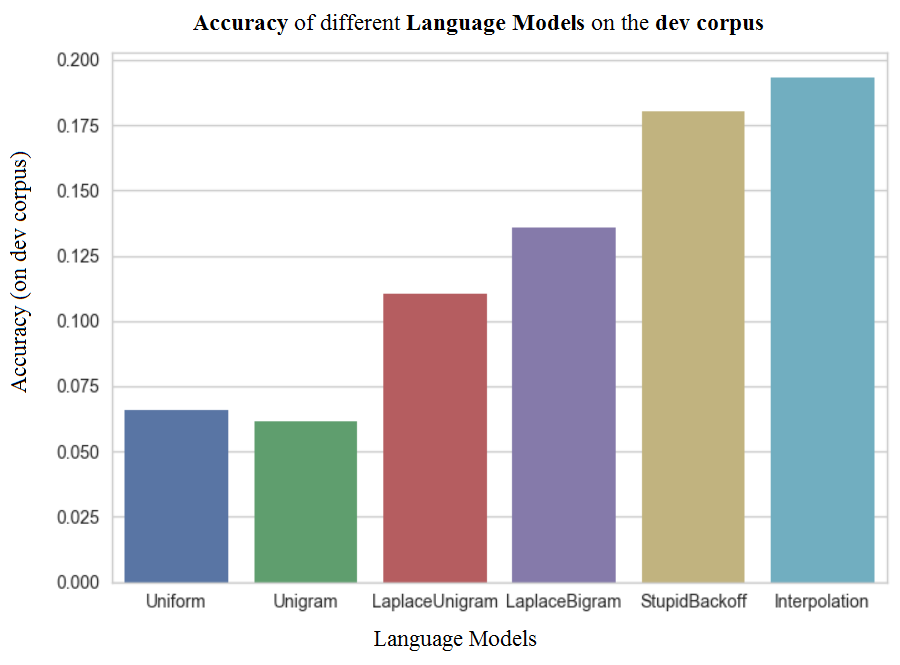

In [6]:
Image(filename='C:/courses/Coursera/Past/NLP/Stanford - NLP/Assignment/pa2-autocorrect-v1/im3.png')

The following table shows some sentences from the **dev corpus** with **misspelt word(s)** along with the **ground truths** and the noisy channel model-corrected outputs with different **language models**. 

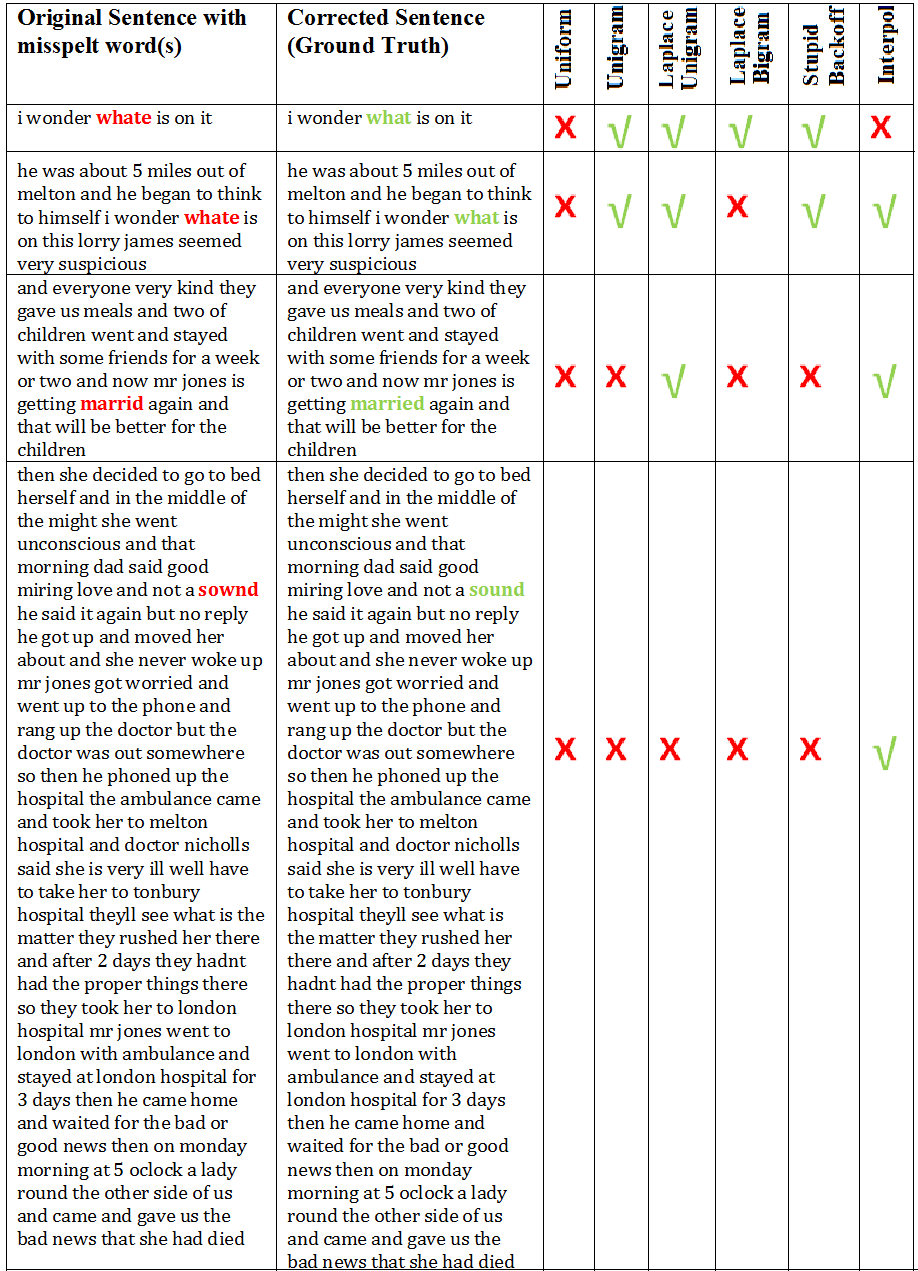

In [7]:
Image(filename='C:/courses/Coursera/Past/NLP/Stanford - NLP/Assignment/pa2-autocorrect-v1/im4.png')

The next figure shows the **simple linear interpolation language model** accuracy on **dev corpus** with different values of $\lambda_1$ and $\lambda_2$.

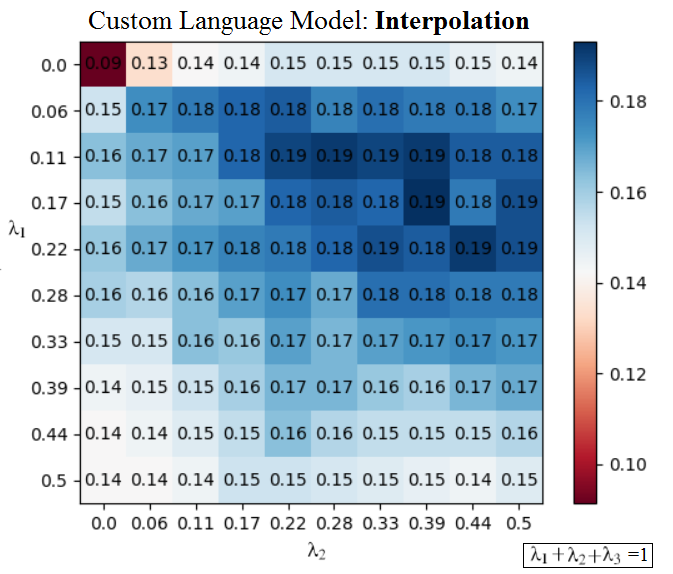

In [5]:
Image(filename='C:/courses/Coursera/Past/NLP/Stanford - NLP/Assignment/pa2-autocorrect-v1/im2.png')

In [ ]:
import collections

class EditModel:
    
  alphabet = 'abcdefghijklmnopqrstuvwxyz'

  def __init__(self, edit_file='../data/count_1edit.txt', corpus=None):
    self.edit_file = edit_file
    self.edit_table = self.read_edit_table(self.edit_file)
    if corpus:
      self.initVocabulary(corpus)

  def initVocabulary(self, corpus):
   self.vocabulary = set()
   for sentence in corpus.corpus:
    for datum in sentence.data:
      self.vocabulary.add(datum.word)
  
  
  
  def editProbabilities(self, word):
    """Computes p(x|word) edit model for a given word. Returns a dictionary mapping x -> p(x|word)."""
    s = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    counts = collections.defaultdict(lambda: 0)
    # deletes
    for a, b in s:
      if b and a + b[1:] in self.vocabulary:
        tail = ''
        if len(a) > 0:
          tail = a[-1]
        original = tail + b[0]
        replacement = tail
        count = self.edit_count(original, replacement)
        if count:
          counts[a + b[1:]] += count
    # transposes
    for a, b in s:
      if len(b)>1 and a + b[1] + b[0] + b[2:] in self.vocabulary:
        # new word is a + b[1] + b[0] + b[2:]
        # edit is b[0]b[1] -> b[1]b[0]
        original = b[0] + b[1]
        replacement = b[1] + b[0]
        count = self.edit_count(original, replacement)
        if count:
          counts[a + b[1] + b[0] + b[2:]] += count
    # replaces
    for a, b in s:
      if b: 
        for c in self.alphabet:
          if a + c + b[1:] in self.vocabulary:
            # new word is a + c + b[1:]. 
            original = b[0]
            replacement = c
            count = self.edit_count(original, replacement)
            if count:
              counts[a + c + b[1:]] += count
    # inserts
    for a, b in s:
      for c in self.alphabet:
        if a + c + b in self.vocabulary:
          # new word is a + c + b. 
          tail = ''
          if len(a) > 0:
            tail = a[-1]
          original = tail
          replacement = tail + c
          count = self.edit_count(original, replacement)
          if count:
            counts[a + c + b] += count
  
    # normalize counts. sum over them all, divide each entry by sum.
    total = 0.0
    for a,b in counts.iteritems():
      total += b
    # self count
    selfCount = max(9*total, 1)
    counts[word] = selfCount
    total += selfCount
    probs = {}
    if(total != 0.0): 
      for a,b in counts.iteritems():
        probs[a] = float(b)/total
    return probs
        
  def read_edit_table(self, file_name):
    """Reads in the string edit counts file. Stores a dictionary of tuples
      (s1,s2) -> count."""
    edit_table = collections.defaultdict(lambda: 0)
    f = file(file_name)
    for line in f:
      contents = line.split('\t')
      edit_table[contents[0]] = int(contents[1])
    return edit_table
  
  
  def edit_count(self, s1, s2):
    """Returns how many times substring s1 is edited as s2."""  
    return self.edit_table[s1 + "|" + s2]
  

# taken from http://mwh.geek.nz/2009/04/26/python-damerau-levenshtein-distance/
# MIT license.
def dameraulevenshtein(seq1, seq2):
    """Calculate the Damerau-Levenshtein distance between sequences.

    This distance is the number of additions, deletions, substitutions,
    and transpositions needed to transform the first sequence into the
    second. Although generally used with strings, any sequences of
    comparable objects will work.

    Transpositions are exchanges of *consecutive* characters; all other
    operations are self-explanatory.

    This implementation is O(N*M) time and O(M) space, for N and M the
    lengths of the two sequences.

    >>> dameraulevenshtein('ba', 'abc')
    2
    >>> dameraulevenshtein('fee', 'deed')
    2

    It works with arbitrary sequences too:
    >>> dameraulevenshtein('abcd', ['b', 'a', 'c', 'd', 'e'])
    2
    """
    # codesnippet:D0DE4716-B6E6-4161-9219-2903BF8F547F
    # Conceptually, this is based on a len(seq1) + 1 * len(seq2) + 1 matrix.
    # However, only the current and two previous rows are needed at once,
    # so we only store those.
    oneago = None
    thisrow = range(1, len(seq2) + 1) + [0]
    for x in xrange(len(seq1)):
        # Python lists wrap around for negative indices, so put the
        # leftmost column at the *end* of the list. This matches with
        # the zero-indexed strings and saves extra calculation.
        twoago, oneago, thisrow = oneago, thisrow, [0] * len(seq2) + [x + 1]
        for y in xrange(len(seq2)):
            delcost = oneago[y] + 1
            addcost = thisrow[y - 1] + 1
            subcost = oneago[y - 1] + (seq1[x] != seq2[y])
            thisrow[y] = min(delcost, addcost, subcost)
            # This block deals with transpositions
            if (x > 0 and y > 0 and seq1[x] == seq2[y - 1]
                and seq1[x-1] == seq2[y] and seq1[x] != seq2[y]):
                thisrow[y] = min(thisrow[y], twoago[y - 2] + 1)
    return thisrow[len(seq2) - 1]


In [ ]:
import re
#from EditModel import *

class Datum:
  word = '' # the correct word
  error = '' # the error word (if any)

  def __init__(self):
    self.word = ''
    self.error = ''

  def __init__(self, word, error=''):
    self.word = word
    self.error = error

  def fixError(self):
    return Datum(self.word, '')

  def hasError(self):
    if self.error:
      return True
    else:
      return False

  def isValidTest(self):
    """Returns true if the error is within edit distance one and contains no numerics/punctuation."""
    if not self.hasError():
      return False
    distance = dameraulevenshtein(self.word, self.error) 
    if(distance > 1):
      return False
    regex = '.*[^a-zA-Z].*'
    if re.match(regex, self.word) or re.match(regex, self.error):
      return False
    return True

  def __str__(self):
    """Format: word (error)?"""
    rep = self.word 
    if self.hasError():
      rep = rep + " (" + self.error + ")"
    return rep


In [ ]:
class Sentence:
  """Contains a list of Datums."""

  def __init__(self, sentence=[]):
    if(type(sentence) == type([])):
      self.data = list(sentence) 
    else:
      self.data = list(sentence.data)
  
  def getErrorSentence(self):
    """Returns a list of strings with the sentence containing all errors."""
    errorSentence = []
    for datum in self.data:
      if datum.hasError():
        errorSentence.append(datum.error)
      else:
        errorSentence.append(datum.word)
    return errorSentence

  def getCorrectSentence(self):
    """Returns a list of strings with the sentence containing all corrections."""
    correctSentence = []
    for datum in self.data:
      if datum.hasError():
        correctSentence.append(datum.error)
      else:
        correctSentence.append(datum.word)
    return correctSentence

  def isCorrection(self, candidate):
    """Checks if a list of strings is a correction of this sentence."""
    if len(self.data) != len(candidate):
      return False
    for i in range(0,len(self.data)):
      if not candidate[i] == self.data[i].word:
        return False
    return True

  def getErrorIndex(self):
    for i in range(0, len(self.data)):
      if self.data[i].hasError():
        return i
    return -1

  def len(self):
    return len(self.data)

  def get(self, i):
    return self.data[i]

  def put(self, i, val):
    self.data[i] = val

  def cleanSentence(self):
    """Returns a new sentence with all datum's having error removed."""
    sentence = Sentence()
    for datum in self.data:
      clean = datum.fixError()
      sentence.append(clean)
    return sentence

  def isEmpty(self):
    return len(self.data) == 0

  def append(self, item):    
    self.data.append(item)

  def __len__(self):
    return len(self.data)

  def __str__(self):
    str_list = []
    for datum in self.data:
      str_list.append(str(datum))
    return ' '.join(str_list)


In [ ]:
#from Datum import Datum
#from Sentence import Sentence

class HolbrookCorpus:
  corpus = [] # list of sentences

  def __init__(self, filename=None):
    if filename:
      self.read_holbrook(filename)
    else:
      self.corpus = []

  def processLine(self, line):
   line = line.strip()
   line = line.lower() 
   line = line.replace('"','') 
   line = line.replace(',', '')
   line = line.replace('.','') 
   line = line.replace('!','') 
   line = line.replace("'",'') 
   line = line.replace(":",'') 
   line = line.replace(";",'') 
   if line == '':
     return None
   processed_tokens = Sentence() 
   processed_tokens.append(Datum("<s>")) #start symbol
   tokens = line.split()
   i = 0
   while i < len(tokens):
     token = tokens[i]
     if token == '<err':
       targ = tokens[i+1]
       targ_splits = targ.split('=')
       correct_token = targ_splits[1][:-1] # chop off the trailing '>'
       correct_token_splits = correct_token.split()
       if len(correct_token_splits) > 2: # targ with multiple words
         #print 'targ with multiple words: "%s"' % targ
         for correct_word in correct_token_splits:
           processed_tokens.append(Datum(correct_word))
       elif tokens[i+3] != '</err>':
         processed_tokens.append(Datum(correct_token))
       else:
         incorrect_token = tokens[i+2]
         processed_tokens.append(Datum(correct_token, incorrect_token))    
       i += tokens[i:].index('</err>') + 1 # update index
     else: # regular word
       processed_tokens.append(Datum(token))
       i += 1
   processed_tokens.append(Datum("</s>"))
   return processed_tokens
  
  def read_holbrook(self, filename):
    """Read in holbrook data, returns a list (sentence) of list(words) of lists(alternatives).
       The first item in each word list is the correct word."""
    f = open(filename)
    self.corpus = []
    for line in f:
      sentence = self.processLine(line)      
      if sentence:
        self.corpus.append(sentence)
  
  
  def generateTestCases(self):  
    """Returns a list of sentences with exactly 1 elligible spelling error"""
    testCases = [] # list of Sentences
    for sentence in self.corpus:
      cleanSentence = sentence.cleanSentence()
      for i in range(0, len(sentence)):
        datum_i = sentence.get(i)
        if datum_i.hasError() and datum_i.isValidTest():
          testSentence = Sentence(cleanSentence)
          testSentence.put(i, datum_i)
          testCases.append(testSentence)
    return testCases

  
  def slurpString(self, contents):
    """Reads a clean corpus from string instead of file. Used for submission."""
    lines = contents.split('\n')
    self.corpus = []
    for line in lines:
      sentence = self.processLine(line)
      if sentence:
        self.corpus.append(sentence)

  def __str__(self):
    str_list = []
    for sentence in self.corpus:
      str_list.append(str(sentence))
    return '\n'.join(str_list)   



In [ ]:
import math, collections

class UniformLanguageModel:

  def __init__(self, corpus):
    """Initialize your data structures in the constructor."""
    self.words = set([])
    self.train(corpus)

  def train(self, corpus):
    """ Takes a corpus and trains your language model. 
        Compute any counts or other corpus statistics in this function.
    """  
    for sentence in corpus.corpus: # iterate over sentences in the corpus
      for datum in sentence.data: # iterate over datums in the sentence
        word = datum.word # get the word
        self.words.add(word)

  def score(self, sentence):
    """ Takes a list of strings as argument and returns the log-probability of the 
        sentence using your language model. Use whatever data you computed in train() here.
    """
    score = 0.0
    probability = math.log(1.0/len(self.words))
    for token in sentence: # iterate over words in the sentence
      score += probability
    # NOTE: a simpler method would be just score = sentence.size() * - Math.log(words.size()).
    # we show the 'for' loop for insructive purposes.
    return score


In [ ]:
import math, collections


class UnigramLanguageModel:

  def __init__(self, corpus):
    self.unigramCounts = collections.defaultdict(lambda: 0)
    self.total = 0
    self.train(corpus)

  def train(self, corpus):
    """Takes a HolbrookCorpus corpus, does whatever training is needed."""
    for sentence in corpus.corpus:
      for datum in sentence.data:  
        token = datum.word
        self.unigramCounts[token] = self.unigramCounts[token] + 1
        self.total += 1
  
  def score(self, sentence):
    """Takes a list of strings, returns a score of that sentence."""
    score = 0.0 
    for token in sentence:
      count = self.unigramCounts[token]
      if count > 0:
        score += math.log(count)
        score -= math.log(self.total)
      else:
        score = float('-inf') # not smoothed
    return score


In [ ]:
class LaplaceUnigramLanguageModel:

  def __init__(self, corpus):
    """Initialize your data structures in the constructor."""
    # TODO your code here
    self.unigramCounts = collections.defaultdict(lambda: 0)
    self.total = 0
    self.train(corpus)

  def train(self, corpus):
    """ Takes a corpus and trains your language model. 
        Compute any counts or other corpus statistics in this function.
    """  
    # TODO your code here
    for sentence in corpus.corpus:
      for datum in sentence.data:  
        token = datum.word
        self.unigramCounts[token] = self.unigramCounts[token] + 1
        self.total += 1  

  def score(self, sentence):
    """ Takes a list of strings as argument and returns the log-probability of the 
        sentence using your language model. Use whatever data you computed in train() here.
    """
    # TODO your code here
    """Takes a list of strings, returns a score of that sentence."""
    score = 0.0 
    for token in sentence:
      count = self.unigramCounts[token]
      score += math.log(count + 1)
      score -= math.log(self.total + len(self.unigramCounts))
    return score


In [ ]:
class LaplaceBigramLanguageModel:

  def __init__(self, corpus):
    """Initialize your data structures in the constructor."""
    # TODO your code here
    self.unigramCounts = collections.defaultdict(lambda: 0)
    self.bigramCounts = collections.defaultdict(lambda: 0)
    self.total = 0
    self.train(corpus)

  def train(self, corpus):
    """ Takes a corpus and trains your language model. 
        Compute any counts or other corpus statistics in this function.
    """  
    # TODO your code here
    for sentence in corpus.corpus:
      prev_token = None
      for datum in sentence.data:  
        token = datum.word
        self.unigramCounts[token] += 1
        self.total += 1  
        if prev_token:    
           self.bigramCounts[prev_token, token] += 1
        prev_token = token

  def score(self, sentence):
    """ Takes a list of strings as argument and returns the log-probability of the 
        sentence using your language model. Use whatever data you computed in train() here.
    """
    # TODO your code here
    score = 0.0 
    prev_token = None
    for token in sentence:
      if prev_token == None:
          count = self.unigramCounts[token]
          score += math.log(count + 1)
          score -= math.log(self.total + len(self.unigramCounts))
      else:
          count2 = self.bigramCounts[prev_token,token]
          count1 = self.unigramCounts[prev_token]
          score += math.log(count2 + 1)
          score -= math.log(count1 + len(self.unigramCounts))
      prev_token = token
        
    return score


In [ ]:
class StupidBackoffLanguageModel:

  def __init__(self, corpus):
    """Initialize your data structures in the constructor."""
    # TODO your code here
    self.train(corpus)

  def train(self, corpus):
    """ Takes a corpus and trains your language model. 
        Compute any counts or other corpus statistics in this function.
    """  
    # TODO your code here
    pass

  def score(self, sentence):
    """ Takes a list of strings as argument and returns the log-probability of the 
        sentence using your language model. Use whatever data you computed in train() here.
    """
    # TODO your code here
    return 0.0


In [ ]:
class CustomLanguageModel:

  def __init__(self, corpus):
    """Initialize your data structures in the constructor."""
    # TODO your code here
    self.train(corpus)

  def train(self, corpus):
    """ Takes a corpus and trains your language model. 
        Compute any counts or other corpus statistics in this function.
    """  
    # TODO your code here
    pass

  def score(self, sentence):
    """ Takes a list of strings as argument and returns the log-probability of the 
        sentence using your language model. Use whatever data you computed in train() here.
    """
    # TODO your code here
    return 0.0


In [ ]:
class SpellingResult:
  numCorrect = 0
  numTotal = 0

  def __init__(self):
    self.numCorrect = 0
    self.numTotal = 0

  def __init__(self, correct, total):
    self.numCorrect = correct
    self.numTotal = total
  
  def getAccuracy(self):
    if self.numTotal == 0:
      return 0.0
    else:
      return float(self.numCorrect) / self.numTotal

  def __str__(self):
    return 'correct: %d total: %d accuracy: %f' % (self.numCorrect, self.numTotal, self.getAccuracy())


In [ ]:
import math
import types
#from Datum import Datum
#from Sentence import Sentence
#from HolbrookCorpus import HolbrookCorpus
#from UniformLanguageModel import UniformLanguageModel
#from UnigramLanguageModel import UnigramLanguageModel
#from StupidBackoffLanguageModel import StupidBackoffLanguageModel
#from LaplaceUnigramLanguageModel import LaplaceUnigramLanguageModel
#from LaplaceBigramLanguageModel import LaplaceBigramLanguageModel
#from CustomLanguageModel import CustomLanguageModel
#from EditModel import EditModel
#from SpellingResult import SpellingResult

# Modified version of Peter Norvig's spelling corrector
"""Spelling Corrector.

Copyright 2007 Peter Norvig. 
Open source code under MIT license: http://www.opensource.org/licenses/mit-license.php
"""

import re, collections

class SpellCorrect:
  """Holds edit model, language model, corpus. trains"""
  

  def __init__(self, lm, corpus):
    """initializes the language model."""
    self.languageModel = lm
    self.editModel = EditModel('C:/courses/Coursera/Past/NLP/Stanford - NLP/Assignment/pa2-autocorrect-v1/data/count_1edit.txt', corpus)


  def evaluate(self, corpus):  
    """Tests this speller on a corpus, returns a SpellingResult"""
    numCorrect = 0
    numTotal = 0
    testData = corpus.generateTestCases()
    for sentence in testData:
      if sentence.isEmpty():
        continue
      errorSentence = sentence.getErrorSentence()
      hypothesis = self.correctSentence(errorSentence)
      if sentence.isCorrection(hypothesis):
        numCorrect += 1
      numTotal += 1
    return SpellingResult(numCorrect, numTotal)

  def correctSentence(self, sentence):
    """Takes a list of words, returns a corrected list of words."""
    if len(sentence) == 0:
      return []
    argmax_i = 0
    argmax_w = sentence[0]
    maxscore = float('-inf')
    maxlm = float('-inf')
    maxedit = float('-inf')

    # skip start and end tokens
    for i in range(1, len(sentence) - 1):
      word = sentence[i]
      editProbs = self.editModel.editProbabilities(word)
      for alternative, editscore in editProbs.iteritems():
        if alternative == word:
          continue
        sentence[i] = alternative
        lmscore = self.languageModel.score(sentence)
        if editscore != 0:
          editscore = math.log(editscore)
        else:
          editscore = float('-inf')
        score = lmscore + editscore
        if score >= maxscore:
          maxscore = score
          maxlm = lmscore
          maxedit = editscore
          argmax_i = i
          argmax_w = alternative

      sentence[i] = word # restores sentence to original state before moving on
    argmax = list(sentence) # copy it
    argmax[argmax_i] = argmax_w # correct it
    return argmax


  def correctCorpus(self, corpus): 
    """Corrects a whole corpus, returns a JSON representation of the output."""
    string_list = [] # we will join these with commas,  bookended with []
    sentences = corpus.corpus
    for sentence in sentences:
      uncorrected = sentence.getErrorSentence()
      corrected = self.correctSentence(uncorrected) # List<String>
      word_list = '["%s"]' % '","'.join(corrected)
      string_list.append(word_list)
    output = '[%s]' % ','.join(string_list)
    return output
    
def main():
  """Trains all of the language models and tests them on the dev data. Change devPath if you wish to do things like test on the training data."""
  print 'here'
  trainPath = 'C:/courses/Coursera/Past/NLP/Stanford - NLP/Assignment/pa2-autocorrect-v1/data/holbrook-tagged-train.dat'
  trainingCorpus = HolbrookCorpus(trainPath)

  devPath = 'C:/courses/Coursera/Past/NLP/Stanford - NLP/Assignment/pa2-autocorrect-v1/data/holbrook-tagged-dev.dat'
  devCorpus = HolbrookCorpus(devPath)

  print 'Uniform Language Model: '
  uniformLM = UniformLanguageModel(trainingCorpus)
  uniformSpell = SpellCorrect(uniformLM, trainingCorpus)
  uniformOutcome = uniformSpell.evaluate(devCorpus) 
  print str(uniformOutcome)

  print 'Laplace Unigram Language Model: ' 
  laplaceUnigramLM = LaplaceUnigramLanguageModel(trainingCorpus)
  laplaceUnigramSpell = SpellCorrect(laplaceUnigramLM, trainingCorpus)
  laplaceUnigramOutcome = laplaceUnigramSpell.evaluate(devCorpus)
  print str(laplaceUnigramOutcome)

  print 'Laplace Bigram Language Model: '
  laplaceBigramLM = LaplaceBigramLanguageModel(trainingCorpus)
  laplaceBigramSpell = SpellCorrect(laplaceBigramLM, trainingCorpus)
  laplaceBigramOutcome = laplaceBigramSpell.evaluate(devCorpus)
  print str(laplaceBigramOutcome)

  print 'Stupid Backoff Language Model: '  
  sbLM = StupidBackoffLanguageModel(trainingCorpus)
  sbSpell = SpellCorrect(sbLM, trainingCorpus)
  sbOutcome = sbSpell.evaluate(devCorpus)
  print str(sbOutcome)

  print 'Custom Language Model: '
  customLM = CustomLanguageModel(trainingCorpus)
  customSpell = SpellCorrect(customLM, trainingCorpus)
  customOutcome = customSpell.evaluate(devCorpus)
  print str(customOutcome)

#if __name__ == "__main__":
main()